# Example of usage Spark OCR with Dicom Image Deidentifier

#🎬 Installation

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

# 🔑 Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')

license_keys = files.upload()

# 🔑  Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, visual

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

#📌 Starting

In [3]:
from johnsnowlabs import nlp, visual
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)

👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.4.1, 💊Spark-Healthcare==4.4.3, 🕶Spark-OCR==4.4.2, running on ⚡ PySpark==3.1.2


In [4]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

## Import Spark OCR transformers and Spark NLP annotators

In [8]:
import os
import sys

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline


## Define de-identification  NLP pipeline

In [9]:
def deidentification_nlp_pipeline(input_column, prefix = "", model="ner_deid_large"):
    document_assembler = DocumentAssembler() \
        .setInputCol(input_column) \
        .setOutputCol(prefix + "document")

    # Sentence Detector annotator, processes various sentences per line
    sentence_detector = SentenceDetector() \
        .setInputCols([prefix + "document"]) \
        .setOutputCol(prefix + "sentence")

    tokenizer = Tokenizer() \
        .setInputCols([prefix + "sentence"]) \
        .setOutputCol(prefix + "token")

    # Clinical word embeddings
    word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token"]) \
        .setOutputCol(prefix + "embeddings")

    clinical_ner = MedicalNerModel.pretrained(model, "en", "clinical/models") \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "embeddings"]) \
        .setOutputCol(prefix + "ner")

    custom_ner_converter = NerConverter() \
        .setInputCols([prefix + "sentence", prefix + "token", prefix + "ner"]) \
        .setOutputCol(prefix + "ner_chunk") \
        .setWhiteList(['NAME', 'AGE', 'CONTACT',
                   'LOCATION', 'PROFESSION', 'PERSON', 'DATE', 'DOCTOR'])

    nlp_pipeline = Pipeline(stages=[
            document_assembler,
            sentence_detector,
            tokenizer,
            word_embeddings,
            clinical_ner,
            custom_ner_converter
        ])
    empty_data = spark.createDataFrame([[""]]).toDF(input_column)
    nlp_model = nlp_pipeline.fit(empty_data)
    return nlp_model

## Define OCR transformers and pipeline for image deidentification

In [10]:
from pyspark.ml import PipelineModel, Pipeline

# Extract images from Dicom foram
dicom_to_image = visual.DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setKeepInput(True)

transform_image = visual.ImageTransformer() \
    .addInvert() \
    .addScalingTransform(3.0) \
    .setInputCol("image_raw") \
    .setOutputCol("transformed_image")

ocr = visual.ImageToText() \
    .setInputCol("transformed_image") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setPageIteratorLevel(PageIteratorLevel.SYMBOL) \
    .setPageSegMode(PageSegmentationMode.SPARSE_TEXT) \
    .setWithSpaces(True)
    # .setModelType(ModelType.BEST)

# Found coordinates of sensitive data
position_finder = visual.PositionFinder() \
    .setInputCols("ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions") \
    .setPadding(0)

# Draw filled rectangle for hide sensitive data
draw_regions = visual.DicomDrawRegions() \
    .setInputCol("content") \
    .setInputRegionsCol("coordinates") \
    .setOutputCol("dicom") \
    .setKeepInput(True) \
    .setScaleFactor(1/3.0) \
    .setAggCols(["path", "content"])

dicom_deidentifier = visual.DicomMetadataDeidentifier() \
    .setInputCols(["dicom"]) \
    .setOutputCol("dicom_cleaned")

# OCR pipeline
pipeline = PipelineModel(stages=[
    dicom_to_image,
    transform_image,
    ocr,
    deidentification_nlp_pipeline(input_column="text", prefix=""),
    position_finder,
    draw_regions,
    dicom_deidentifier
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_deid_large download started this may take some time.
[OK!]


## Read dicom objects as binary file and display metadata


### Useful Patient Identification Tags to check
 - (00100010)	PN	Patient Name
 - (00100020)	LO	Patient ID
 - (00100030)	DA	Patient's Birth Date
 - (00100040)	CS	Patient's Sexe
 - (00101010)	AS	Patient's Age
 - (00101030)	DS	Patient's Weight

In [ ]:
%pip install pydicom

In [13]:
dicom_path = './*.dcm'
dicom_df = spark.read.format("binaryFile").load(dicom_path)

visual.display_dicom(dicom_df)

In [14]:
result = pipeline.transform(dicom_df).cache()

## Show original and de-identified dicom

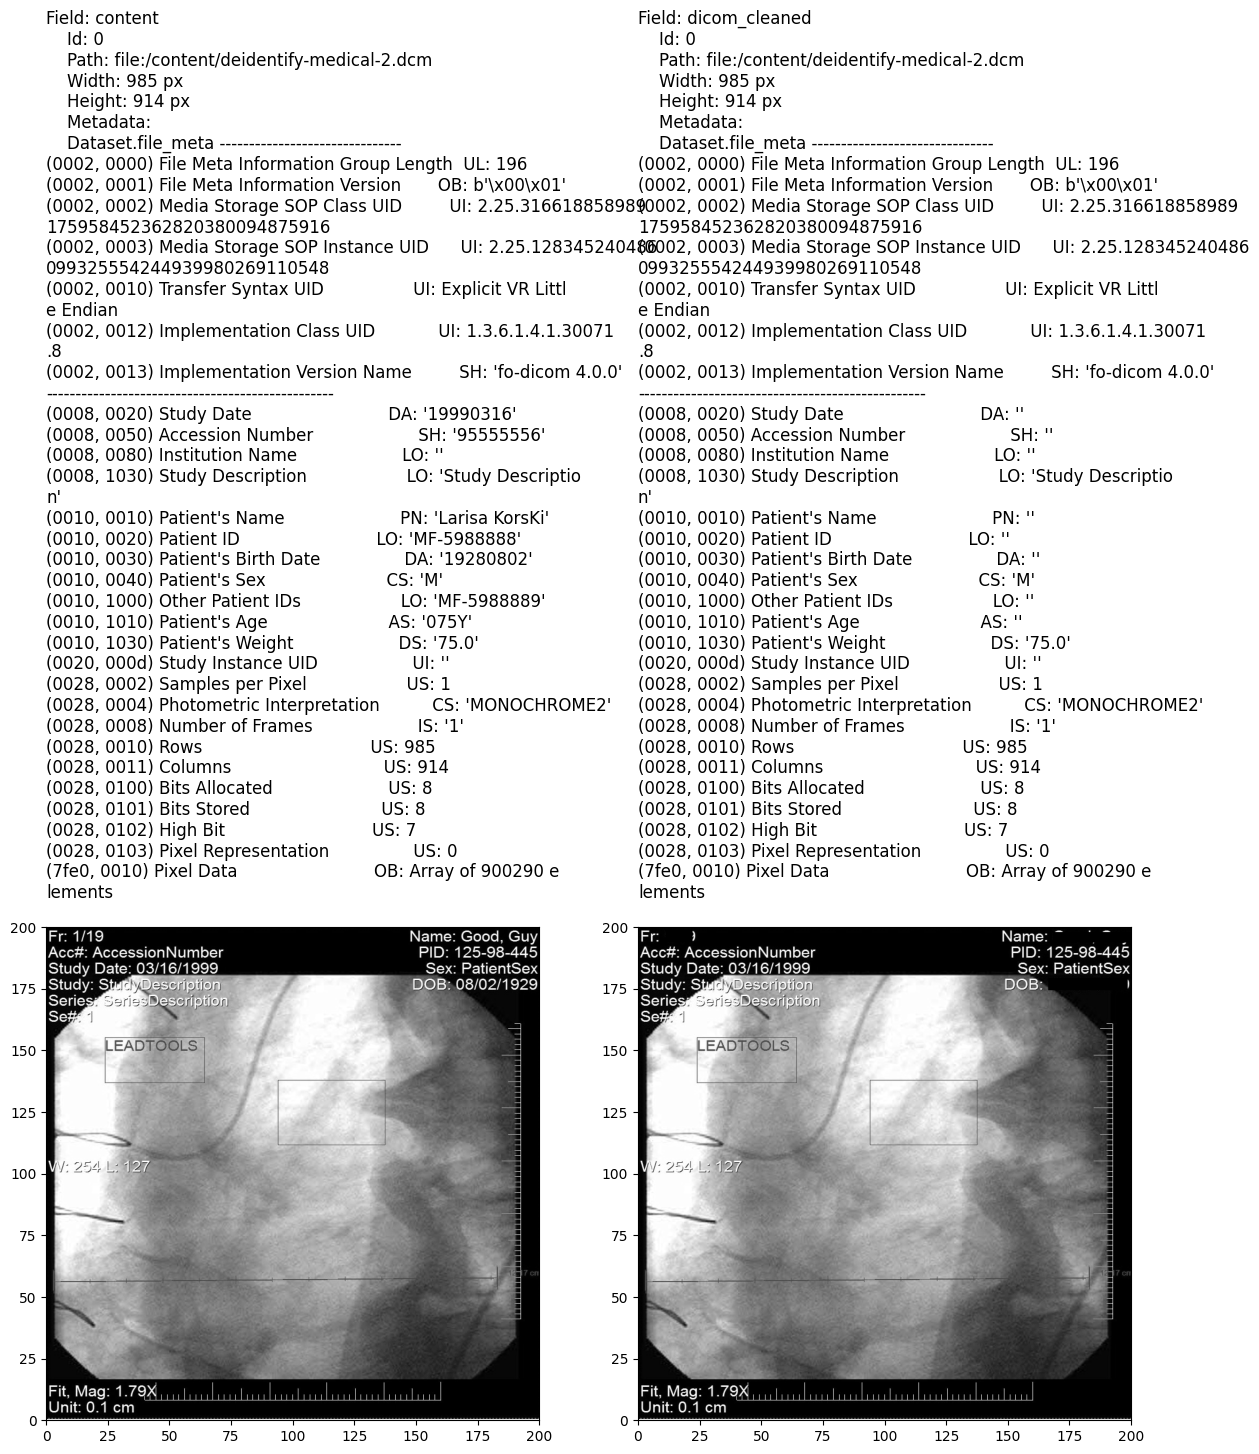

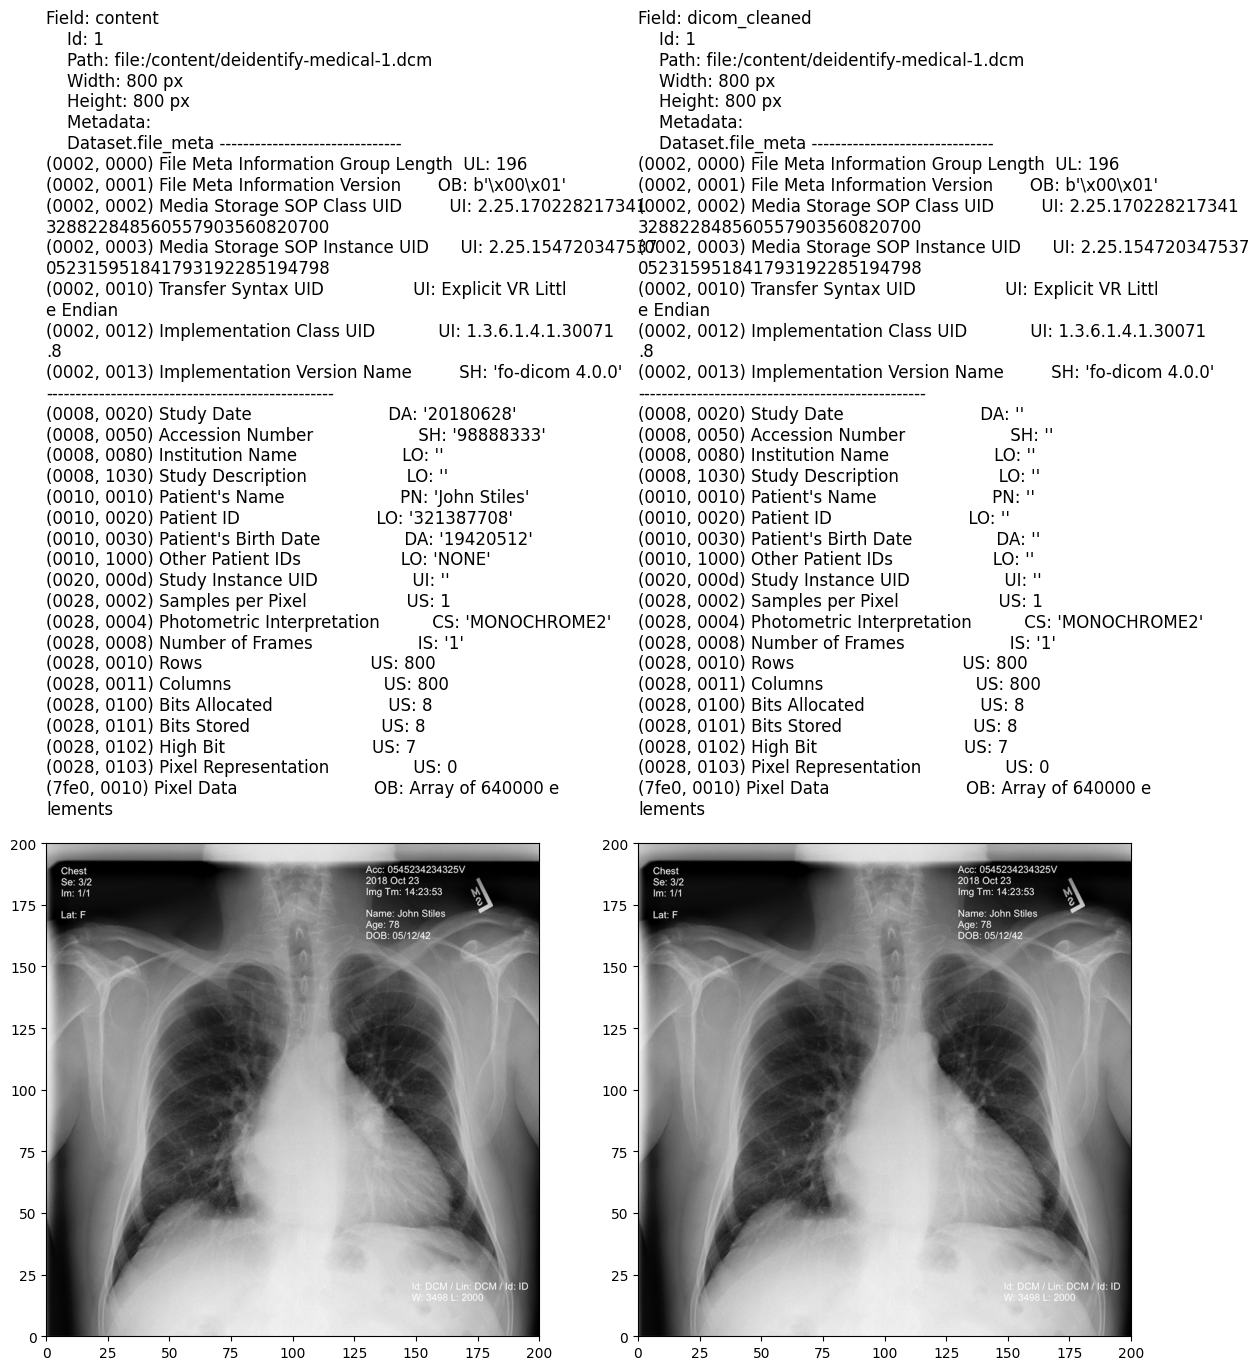

In [16]:
visual.display_dicom(result, "content,dicom_cleaned")

## Run pipeline and store result

In [17]:
# NBVAL_SKIP

output_path = "././data/dicom/deidentified/"
if not os.path.exists(output_path):
    os.makedirs(output_path)

for r in result.select("dicom_cleaned", "path").collect():
    path, name = os.path.split(r.path)
    filename_split = os.path.splitext(name)
    file_name = os.path.join(output_path, filename_split[0]+".dcm")
    print(f"Storing to {file_name}")
    with open(file_name, "wb") as file:
        file.write(r.dicom_cleaned)

Storing to ././data/dicom/deidentified/deidentify-medical-2.dcm
Storing to ././data/dicom/deidentified/deidentify-medical-1.dcm


## Display Deidentified Image and Deidentified metadata

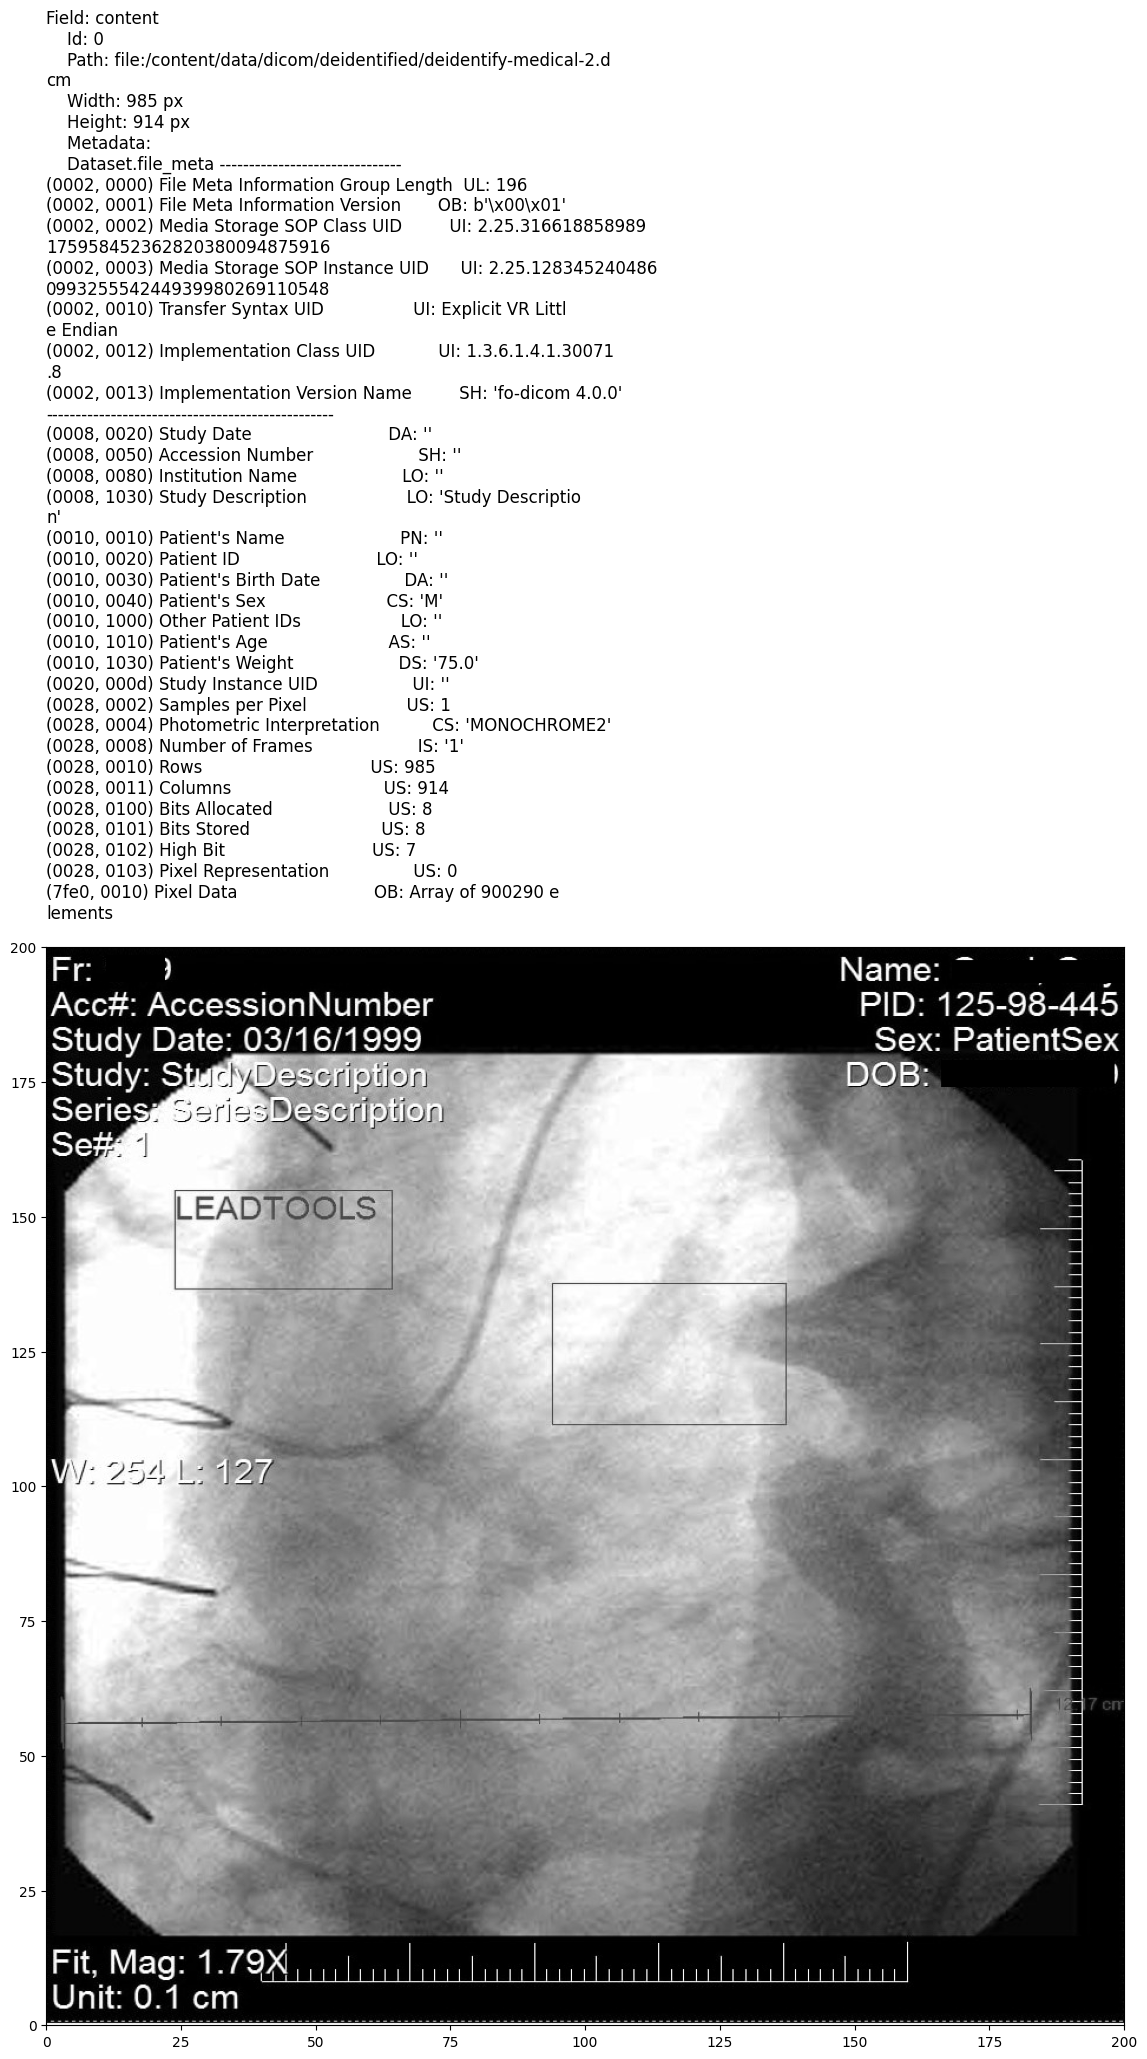

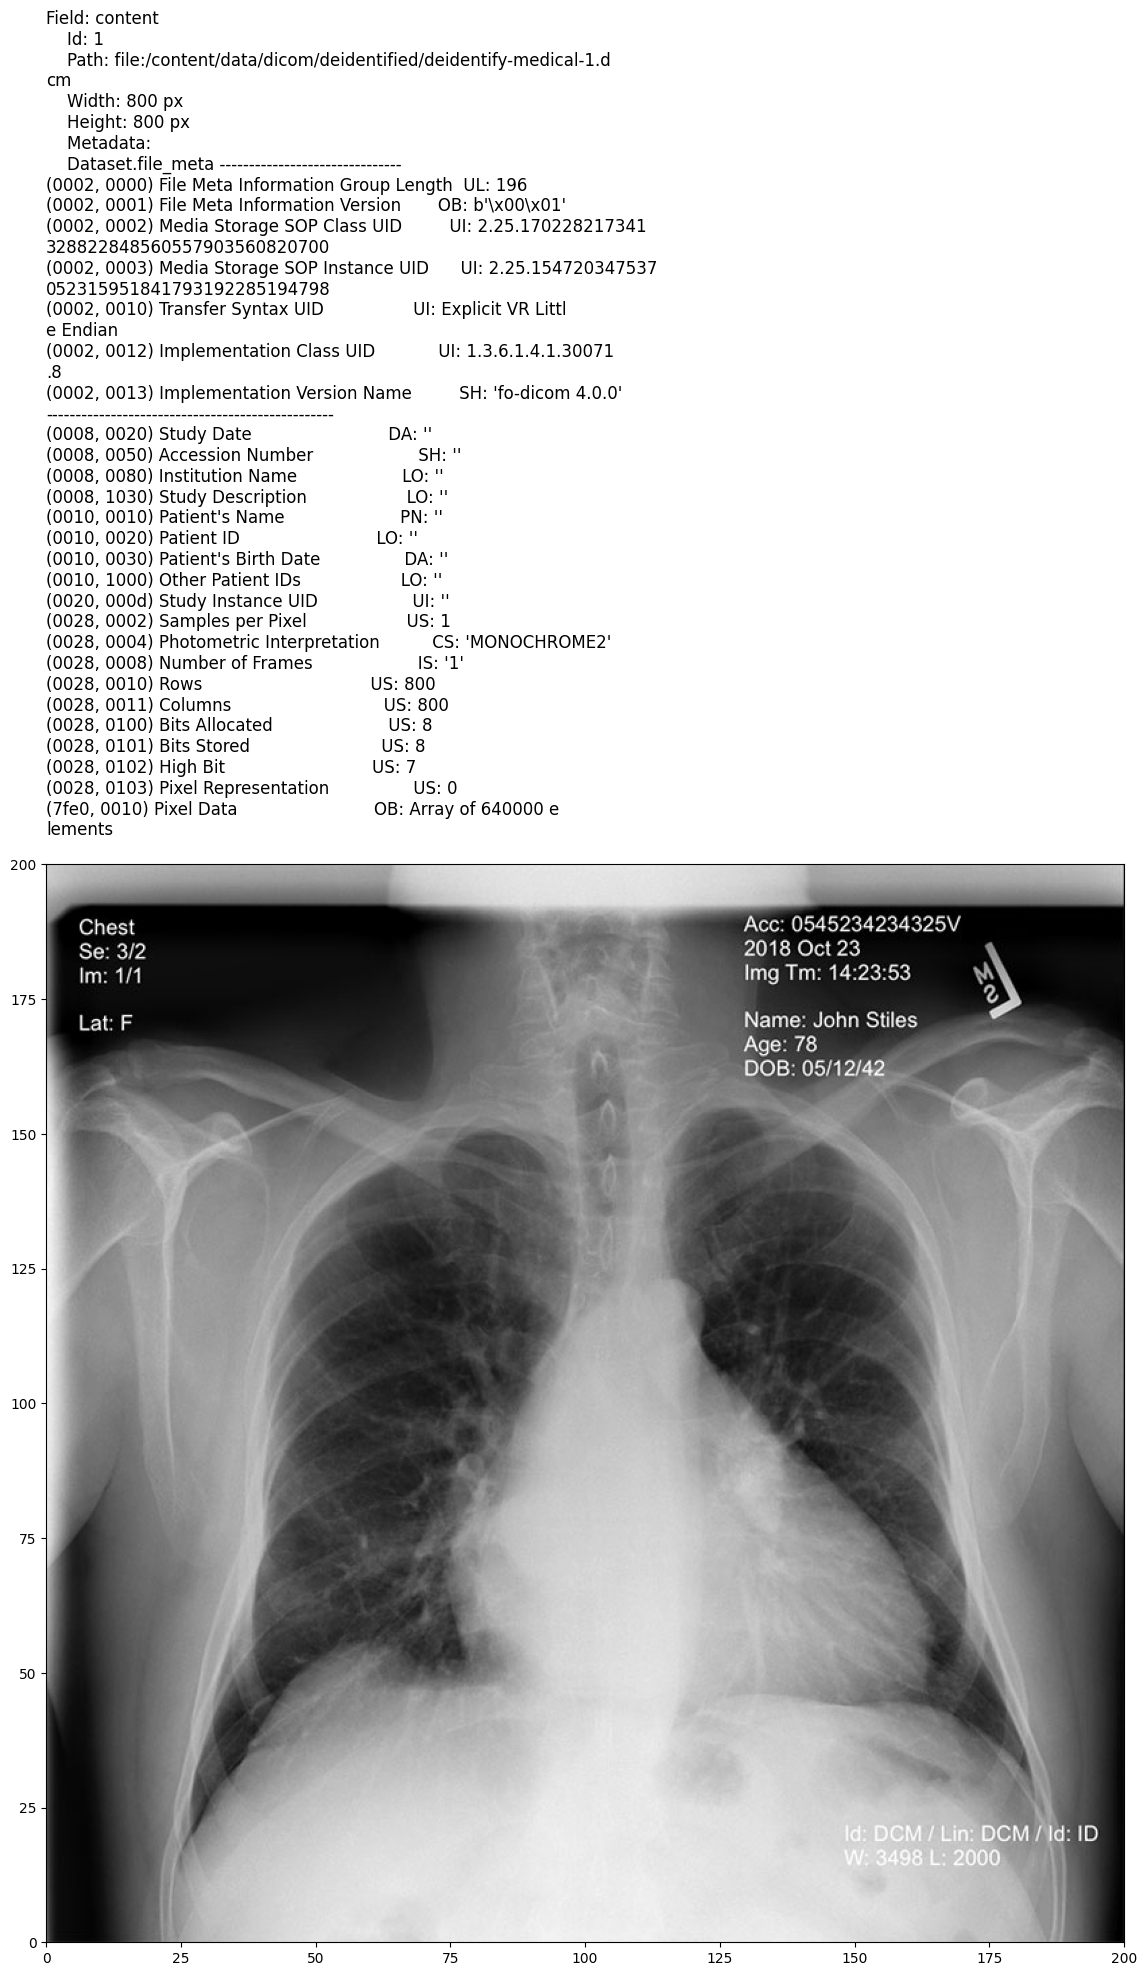

In [18]:
# NBVAL_SKIP
dicom_gen_df = spark.read.format("binaryFile").load("././data/dicom/deidentified/*.dcm")

visual.display_dicom(dicom_gen_df)

## Remove results

In [ ]:
%%bash
rm -r -f ././data/dicom/deidentified